In [28]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [29]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
df = pd.read_parquet('run1.parquet',dtype_backend = 'pyarrow')[['X_jets','y']]

In [30]:
# Set device to cuda
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [31]:
df = df.iloc[:500]

In [32]:
# Convert to numpy arrays
X = np.stack(df['X_jets'].values)
y = df['y'].values


In [33]:
print(X.shape, y.shape)

(500, 3, 125, 125) (500,)


In [34]:
df = None

In [35]:
# Separate into training, validation, and test data

testLen = 0.2*len(X)
X_train = X[:int(len(X)-testLen)]
y_train = y[:int(len(X)-testLen)]

X_test = X[int(len(X)-testLen):]
y_test = y[int(len(X)-testLen):]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(400, 3, 125, 125) (100, 3, 125, 125)
(400,) (100,)


In [36]:
# Separate into training and validation data
valLen = 0.2*len(X_train)
print(valLen)

X_valid = X_train[:int(valLen)]
y_valid = y_train[:int(valLen)]

print(X_valid.shape, y_valid.shape)

X_train = X_train[int(valLen):]
y_train = y_train[int(valLen):]

print(X_train.shape, y_train.shape)

80.0
(80, 3, 125, 125) (80,)
(320, 3, 125, 125) (320,)


In [37]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(320, 3, 125, 125) (80, 3, 125, 125) (100, 3, 125, 125)
(320,) (80,) (100,)


In [38]:
# Take transpose of X data
X_train = np.transpose(X_train, (0,2,3,1))
X_test = np.transpose(X_test, (0,2,3,1))
X_valid = np.transpose(X_valid, (0,2,3,1))

print(X_train.shape, X_valid.shape, X_test.shape)

(320, 125, 125, 3) (80, 125, 125, 3) (100, 125, 125, 3)


In [39]:
# Normalizing the data
mean = np.mean(X_train, axis=(0,1,2,3))
std = np.std(X_train, axis=(0,1,2,3))

In [40]:
X_train = (X_train - mean) / (std + 1e-7)
X_valid = (X_valid - mean) / (std + 1e-7)
#X_test = (X_test - mean) / (std + 1e-7)

In [41]:
# Import necessary libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers


In [42]:
# Build Model Structure (Modified Version Of Alexnet)
base_hidden_units = 32
weight_decay = 1e-4
model = Sequential()

In [43]:
from skimage.transform import resize

# Resize all images to 32,32 in X_train
X_train = np.array([resize(image, (32,32)) for image in X_train])
X_valid = np.array([resize(image, (32,32)) for image in X_valid])
X_test = np.array([resize(image, (32,32)) for image in X_test])

print(X_train.shape, X_valid.shape, X_test.shape)

(320, 32, 32, 3) (80, 32, 32, 3) (100, 32, 32, 3)


In [44]:
print(y_train.shape, y_valid.shape, y_test.shape)

(320,) (80,) (100,)


In [45]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_valid = to_categorical(y_valid, 2)
y_test = to_categorical(y_test, 2)

In [46]:
# Convolutional Layer 1
model.add(Conv2D(base_hidden_units, kernel_size=(3,3),padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Convolutional Layer 2
model.add(Conv2D(base_hidden_units,kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Convolutional Layer 3
model.add(Conv2D(base_hidden_units*2, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#Convolutional Layer 4
model.add(Conv2D(base_hidden_units*2, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Convolutional Layer 5
model.add(Conv2D(base_hidden_units*4, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#Convolutional Layer 6
model.add(Conv2D(base_hidden_units*4, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Fully Connected Layer 1
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()


/home/ayushraina/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 292,898 (1.12 MB)

 Trainable params: 292,002 (1.11 MB)

 Non-trainable params: 896 (3.50 KB)

In [47]:
batch_size = 128
epochs = 50

#USe model checkpoint to save only the best model
checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')

#adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [48]:
import torch    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [49]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf



import tensorflow as tf
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [50]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=[checkpointer], verbose=2, shuffle=True)

Epoch 1/50



Epoch 1: val_accuracy improved from -inf to 0.66250, saving model to model.weights.best.keras
3/3 - 2s - 676ms/step - accuracy: 0.5094 - loss: 3.2996 - val_accuracy: 0.6625 - val_loss: 0.7002
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.66250
3/3 - 0s - 63ms/step - accuracy: 0.5875 - loss: 2.1135 - val_accuracy: 0.6125 - val_loss: 0.6985
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.66250
3/3 - 0s - 63ms/step - accuracy: 0.6719 - loss: 1.6587 - val_accuracy: 0.6375 - val_loss: 0.6972
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.66250
3/3 - 0s - 61ms/step - accuracy: 0.7000 - loss: 1.3004 - val_accuracy: 0.5125 - val_loss: 0.7393
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.66250
3/3 - 0s - 64ms/step - accuracy: 0.5906 - loss: 1.4118 - val_accuracy: 0.5125 - val_loss: 0.7337
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.66250
3/3 - 0s - 62ms/step - accuracy: 0.6406 - loss: 1.1021 - val_accuracy: 0.5625 - val_loss: 0.7152
Epoch 7

In [51]:
scores = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print("\nTest result: %.3f loss: %.3f" % (scores[1]*100,scores[0]))

1/1 - 0s - 21ms/step - accuracy: 0.4500 - loss: 0.7993

Test result: 45.000 loss: 0.799


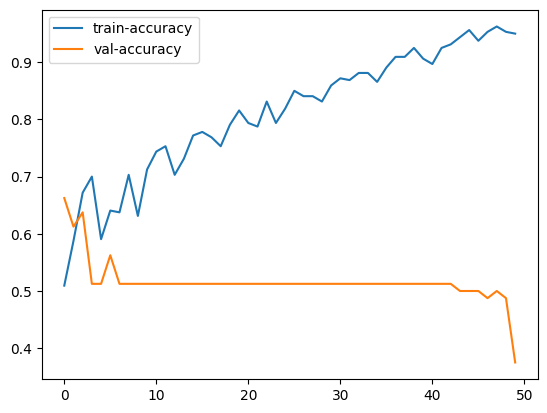

<Figure size 640x480 with 0 Axes>

In [52]:
# plot learning curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train-accuracy')
plt.plot(history.history['val_accuracy'], label='val-accuracy')
plt.legend()
plt.show()

#save this graph
plt.savefig('accuracy.png')

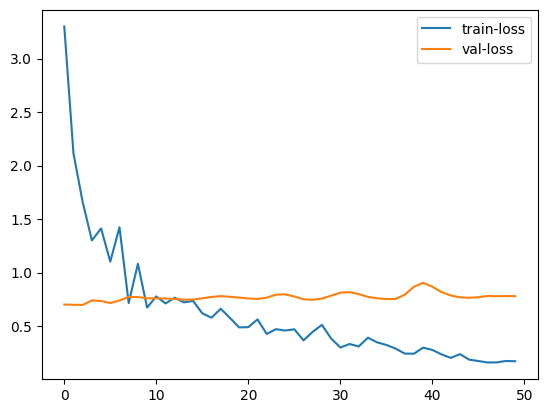

<Figure size 640x480 with 0 Axes>

In [53]:
# Plot traning Loss and validation loss
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.legend()
plt.show()

# save this graph
plt.savefig('loss.png')

In [54]:
#Save the history in a file named accuracies.txt (loss, everthing)
with open('accuracies.txt', 'w') as f:
    
    # Save Training Loss
    f.write('Training Loss: ')
    f.write(str(history.history['loss']))
    f.write('\n')
    
    # Save Validation Loss
    f.write('\nValidation Loss: ')
    f.write(str(history.history['val_loss']))
    f.write('\n')
    
    # Save Training Accuracy
    f.write('\nTraining Accuracy: ')
    f.write(str(history.history['accuracy']))
    f.write('\n')
    
    # Save Validation Accuracy
    f.write('\nValidation Accuracy: ')
    f.write(str(history.history['val_accuracy']))
    f.write('\n')
    
    